# Разработка A/B-тестирования и анализ результатов


* Автор: Игнатьев Валерий
* Дата: 22.11.2025

**Цель проекта:** Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

В проекте предусмотрено 3 таблицы:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Задача проекта
Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
Изучим исторические данныме приложения и изучим структуру датафрейма:

In [1]:
# Импортируем необходимые для работы библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from math import ceil
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

In [2]:
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [3]:
# Изучим строение DF
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


In [4]:
# Выводим первые пять строк для знакомства
sessions_history.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


Датафрейм с историческими данными состоит из 435 924 строчек. Все данные заполнены - пропуска отсутствуют.
Необходимо изменить некорректные типы данных для оптимизации ресурсов выполнения и корректной работы с данными:
* `session_date`, `session_start_ts`, `install_date` содержат значения дат. Можно преобразовать в datetime;
* `session_number`, `page_counter` - числовые значения. Можно снизить разрядность для более быстрых вычислений, тк DF содержит пол миллиона записей;
* `registration_flag`, `region`, `device` - строковые данные с ограниченным набором возможных значений. Для оптимизации ресурсов можно преобразовать их в тип данных category.

In [5]:
# Проведем преобразование в тип даты
for column_name in ['session_date', 'session_start_ts', 'install_date']:
    sessions_history[column_name] = sessions_history[column_name].astype('datetime64')

In [6]:
# Проведем уменьшение разрядности колонок
for column_name in ['session_number','page_counter']:
    sessions_history[column_name] =  pd.to_numeric(sessions_history[column_name], errors='coerce', downcast='integer')

In [7]:
# Проведем преобразование в category
for column_name in ['registration_flag', 'region', 'device']:
    sessions_history[column_name] = sessions_history[column_name].astype('category')

In [8]:
# Повторно изучим строение DF
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            435924 non-null  object        
 1   session_id         435924 non-null  object        
 2   session_date       435924 non-null  datetime64[ns]
 3   session_start_ts   435924 non-null  datetime64[ns]
 4   install_date       435924 non-null  datetime64[ns]
 5   session_number     435924 non-null  int8          
 6   registration_flag  435924 non-null  category      
 7   page_counter       435924 non-null  int8          
 8   region             435924 non-null  category      
 9   device             435924 non-null  category      
dtypes: category(3), datetime64[ns](3), int8(2), object(2)
memory usage: 18.7+ MB


In [9]:
# Проверим явные дубликаты
sessions_history.duplicated().sum()

0

In [10]:
# Проверим неявные дубликаты по ID сессии
sessions_history.duplicated(subset='session_id').sum()

0

Данные в датафрейме обработаны. Данные не содержат пропусков и дубликатов. Можно приступать к расчетам.

#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Изучим таблицу для одного пользователя с наибольшим кол-вом сессий, чтобы лучше понять логику формирования каждого столбца данных.

In [11]:
# Получим кол-во уникальных сессий для каждого пользователя и выведем топ-5 пользователей по кол-ву сессий
user_session = sessions_history.groupby('user_id')['session_id'].count().sort_values(ascending=False).reset_index().rename(columns={'session_id': 'session_count'})
user_session.head()

,user_id,session_count
0,10E0DEFC1ABDBBE0,10
1,6A73CB5566BB494D,10
2,8A60431A825D035B,9
3,D11541BAC141FB94,9
4,5BCFE7C4DCC148E9,9


In [12]:
# Изучим данные из исходного Df для самого активного пользователя
top_user = user_session.iloc[1]['user_id']
sessions_history[sessions_history['user_id'] == top_user]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
124515,6A73CB5566BB494D,110E3F28C1F5415F,2025-08-28,2025-08-28 18:58:19,2025-08-28,1,0,3,MENA,Mac
196252,6A73CB5566BB494D,D68C8D98A0F1C439,2025-08-29,2025-08-29 20:53:27,2025-08-28,2,1,3,MENA,Mac
242428,6A73CB5566BB494D,6587D217472BF807,2025-08-30,2025-08-30 13:08:22,2025-08-28,3,1,1,MENA,Mac
304287,6A73CB5566BB494D,A9BC25593D056F8E,2025-09-01,2025-09-01 18:52:49,2025-08-28,4,1,2,MENA,Mac
346611,6A73CB5566BB494D,CB6F9C4191FAF6F6,2025-09-03,2025-09-03 22:49:08,2025-08-28,5,1,3,MENA,Mac
363510,6A73CB5566BB494D,9C609432F6E6535A,2025-09-04,2025-09-04 13:59:46,2025-08-28,6,1,4,MENA,Mac
391902,6A73CB5566BB494D,5D892E33B97A257A,2025-09-06,2025-09-06 18:46:55,2025-08-28,7,1,2,MENA,Mac
404322,6A73CB5566BB494D,22A9BD3861F49087,2025-09-07,2025-09-07 18:33:49,2025-08-28,8,1,3,MENA,Mac
415489,6A73CB5566BB494D,F70E351154B092DC,2025-09-08,2025-09-08 20:30:22,2025-08-28,9,1,4,MENA,Mac
425805,6A73CB5566BB494D,84A3DC0CFF449F53,2025-09-09,2025-09-09 16:36:04,2025-08-28,10,1,1,MENA,Mac


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

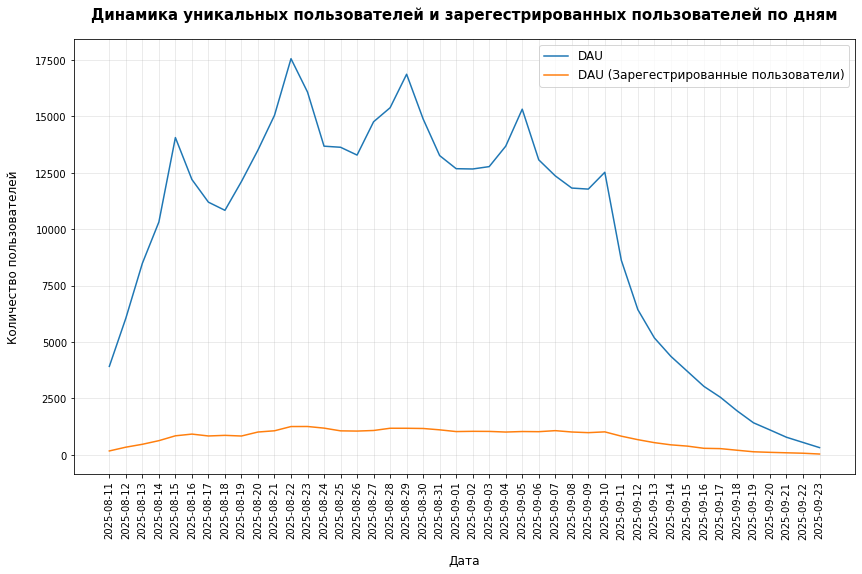

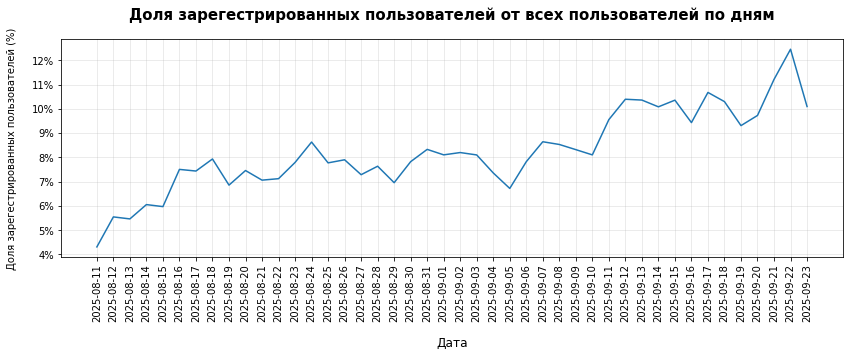

In [13]:
# Строим график пользователей и зарегестрированных пользователей по дням
daily_users = sessions_history.groupby('session_date')['user_id'].count().reset_index().rename(columns={'user_id': 'dau'})
daily_reg_users = sessions_history[sessions_history['registration_flag'] == 1].groupby('session_date')['user_id'].count().reset_index().rename(columns={'user_id': 'dau_reg'})

merge_df = pd.merge(daily_users, daily_reg_users, how='inner', on='session_date')



plt.figure(figsize=(14, 8))

plt.plot(merge_df['session_date'], merge_df['dau'], label='DAU')
plt.plot(merge_df['session_date'], merge_df['dau_reg'], label='DAU (Зарегестрированные пользователи)')

plt.xticks(merge_df['session_date'], rotation=90)
plt.title('Динамика уникальных пользователей и зарегестрированных пользователей по дням', fontsize=15, pad=20, fontweight='bold')
plt.xlabel('Дата', fontsize=12, labelpad=15)
plt.ylabel('Количество пользователей', fontsize=12, labelpad=15)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.show()

# Строим граффик доли зарегестрированных пользователей по дням
merge_df['reg_share'] = merge_df['dau_reg']/merge_df['dau']

plt.figure(figsize=(14, 4))

plt.plot(merge_df['session_date'], merge_df['reg_share'])


plt.xticks(merge_df['session_date'], rotation=90)
plt.title('Доля зарегестрированных пользователей от всех пользователей по дням', fontsize=15, pad=20, fontweight='bold')
plt.xlabel('Дата', fontsize=12, labelpad=15)
plt.ylabel('Доля зарегестрированных пользователей (%)', fontsize=10, labelpad=15)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
plt.grid(True, alpha=0.3)

plt.show()


**Вывод:**
* Пик активности на 20-23 августа среди общего числа пользователей и зарегестрированных пользователей.
* Резкий спад активности всех пользователей в период с 10.09.
* Спад активности зарегестрированных пользователей в период с 10.09.
* Доля зарегестрированных пользователей в период пика трафика составляла от 7% до 9%. с 10.09 она начала расти при общем падении траффика.


#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку. Изучим эту метрику на исторических данных.

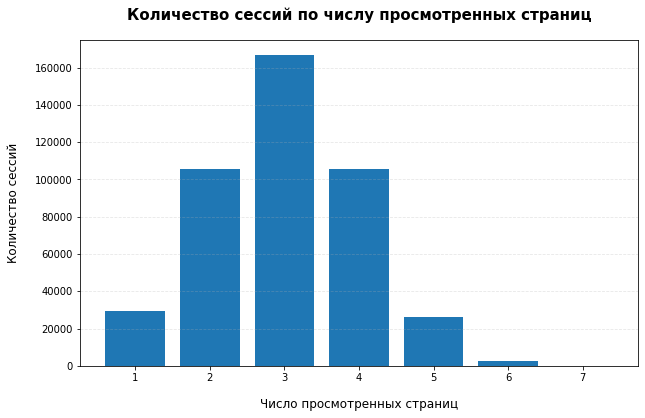

In [14]:
# Строим граффик распределения просмотренных страниц
page_count = sessions_history.groupby('page_counter')['user_id'].count().reset_index().rename(columns={'user_id': 'count_users'})

plt.figure(figsize=(10, 6))
plt.bar(page_count['page_counter'], page_count['count_users'])

plt.title('Количество сессий по числу просмотренных страниц', fontsize=15, pad=20, fontweight='bold')
plt.xlabel('Число просмотренных страниц', fontsize=12, labelpad=15)
plt.ylabel('Количество сессий', fontsize=12, labelpad=15)

plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.show()


**Вывод:**
* Основная часть пользователей за сессию просматривает 3 страницы
* Пользователей которые просматривают 2 страницы и 4 страницы примерно одинаковое кол-во

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта. Изучим его.

In [15]:
# Заполним столбец good_session (0 - сессия менее 4х страниц, 1 - успешная сессия >= 4 страницы)
sessions_history['good_session'] = 0
sessions_history.loc[sessions_history['page_counter'] >= 4, 'good_session'] = 1

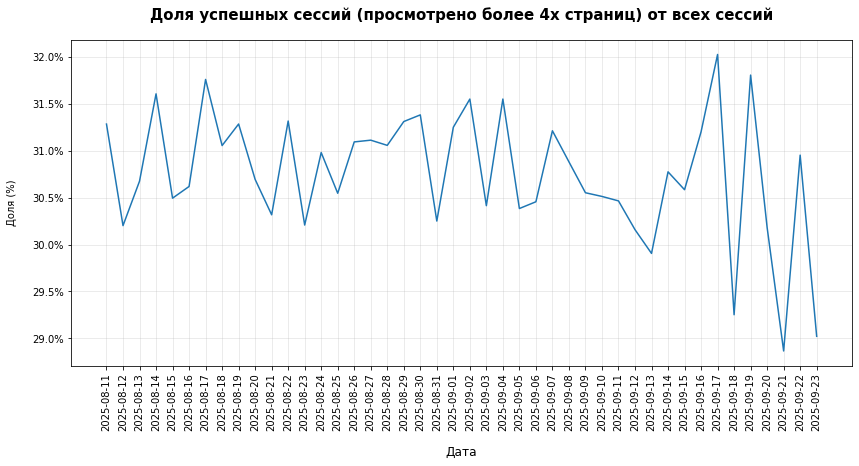

In [16]:
daily_session = sessions_history.groupby('session_date')['session_id'].count().reset_index().rename(columns={'session_id': 'total_session'})
daily_sucess_session = sessions_history[sessions_history['good_session'] == 1].groupby('session_date')['session_id'].count().reset_index().rename(columns={'session_id': 'sucess_session'})

merge_session_df = pd.merge(daily_session, daily_sucess_session, how='inner', on='session_date')

merge_session_df['sucess_share'] = merge_session_df['sucess_session'] / merge_session_df['total_session']



plt.figure(figsize=(14, 6))

plt.plot(merge_session_df['session_date'], merge_session_df['sucess_share'])


plt.xticks(merge_session_df['session_date'], rotation=90)
plt.title('Доля успешных сессий (просмотрено более 4х страниц) от всех сессий', fontsize=15, pad=20, fontweight='bold')
plt.xlabel('Дата', fontsize=12, labelpad=15)
plt.ylabel('Доля (%)', fontsize=10, labelpad=15)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.1f}%'))
plt.grid(True, alpha=0.3)

plt.show()

**Вывод:**
* Данная метрика показывает себя довольно стабильно и колеблется на уровне 29% - 32%.
* Треть сессий успешна - пользователь просмотрел более 4х страниц.

#### Выводы после знакомства с данными:
* Данные логичны и подходят для проведения A/B тестирования
* Пик активности на 20-23 августа среди общего числа пользователей и зарегестрированных пользователей.
* Резкий спад активности всех пользователей в период с 10.09.
* Доля зарегестрированных пользователей в период пика трафика составляла от 7% до 9%. с 10.09 она начала расти при общем падении траффика.
* Основная часть пользователей за сессию просматривает 3 страницы
* Треть сессий успешна - пользователь просмотрел более 4х страниц

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. Изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

Возьмем за метрику - среднее кол-во просмотренных страниц за сессию. Эта метрика поможет показать нам вовлеченность пользователя в просмотр контента. Как утверждалось ранее "сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций"

Выдвенем две гипотезы:

H 
0
​
 : μ 
A
​
 =μ 
B
​
 
 
H 
1
​
 : μ 
A
​
 <μ 
B
​
 




* H0 - Нулевая гипотеза. Между средним значением просмотренных страниц в контрольной и экспериментальной группах нет статистически значимой разницы.
* H1 - Альтернативная гипотеза. Среднее значение просмотренных страниц в экспериментальной группе статистически значимо выше, чем в контрольной.

#### 2.2. Расчёт размера выборки

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста - 0.8.

- Минимальный детектируемый эффект, или MDE, — 0.03.

In [17]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


**Вывод:**
* Показатель для проверки гипотезы - кол-во просмотренных страниц за сессию.
* Необходимый размер выборки для каждой группы: 41 040

#### 2.3. Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитаем длительность теста.

In [18]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 9 дней


**Вывод:**
* Для проведение A/B тестирования при учете среднего траффика - 9 900 пользователей в день и необходимой выборке 41 040 для каждой группы необходимо 9 дней.

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе убедимся, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие нас метрики корректно считаются.

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [19]:
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

In [20]:
# Расчет уникальных пользователей по группам
group_info = sessions_test_part.groupby('test_group')['user_id'].nunique().reset_index().rename(columns={'user_id': 'users'})
group_info

,test_group,users
0,A,1477
1,B,1466


In [21]:
A = group_info[group_info["test_group"] == 'A']['users'].item()
B = group_info[group_info["test_group"] == 'B']['users'].item()

In [22]:
P = 100*((abs(A - B))/A)
f"Процентная разница между группами {P:.3f}%"

'Процентная разница между группами 0.745%'

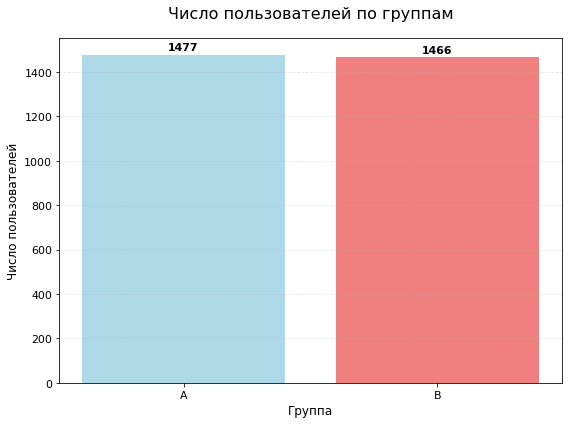

In [23]:
# Строим график
plt.figure(figsize=(8, 6))
plt.bar(group_info['test_group'], group_info['users'], color=['lightblue', 'lightcoral'])

plt.title('Число пользователей по группам', fontsize=16, pad=20)
plt.xlabel('Группа', fontsize=12)
plt.ylabel('Число пользователей', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)


for i, v in enumerate(group_info['users']):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=11, fontweight='bold')


plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод:**
* Группа A - 1477 уникальных пользователей, группа B - 1466 уникальных пользователей
* Разница между группами составляет 0.745%

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, необходимо убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

In [24]:
# Проверяем наличие пользователей в двух группах
users = sessions_test_part.groupby('user_id')['test_group'].nunique()
users[users>1].shape[0]

0

**Вывод:**
* Не найдено пользователей, которые состоят в двух группах.

#### 3.3. Равномерность разделения пользователей по устройствам
Необходимо также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

In [25]:
# Поделим датафрейм на две группы и проведем группировку по устройству
group_A = sessions_test_part[sessions_test_part['test_group'] == 'A']
group_B = sessions_test_part[sessions_test_part['test_group'] == 'B']

group_A_device = group_A.groupby('device')['user_id'].nunique().reset_index().rename(columns={'user_id': 'users'})
group_B_device = group_B.groupby('device')['user_id'].nunique().reset_index().rename(columns={'user_id': 'users'})
group_A_device['share %'] = round(group_A_device['users']/group_A_device['users'].sum() *100,2)
group_B_device['share %'] = round(group_B_device['users']/group_B_device['users'].sum() *100,2)

In [26]:
# Создаем функцию для графиков
def plot_barh_with_shares(df, x_value, share_value,  title, x_label, color_g, size=(12, 5)):
    
    df_sorted = df.sort_values(by=share_value)
    
    ax = df_sorted.plot.barh(
        x=x_value, 
        y=share_value,
        legend=False, 
        color=color_g, 
        figsize=size
    )
    
  
    for i, value in enumerate(df_sorted[share_value]):
        ax.text(
            value, 
            i, 
            f'{value:.2f}%', 
            va='center', 
            ha='left', 
            color='black',
            fontsize=10
        )

    
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.ylabel('')
    plt.title(title, fontsize=15, pad=20, fontweight='bold')
    plt.xlabel(x_label, labelpad=15)
    
    return plt

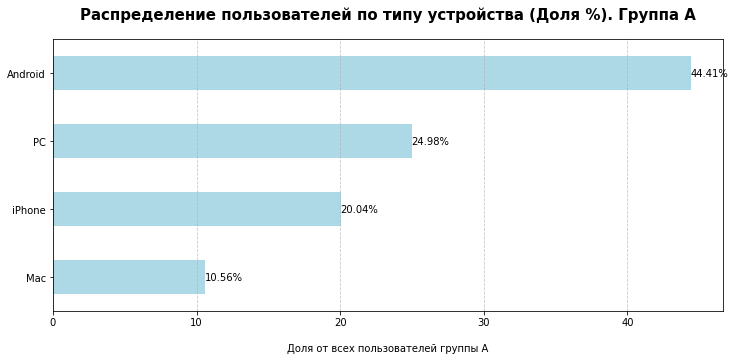

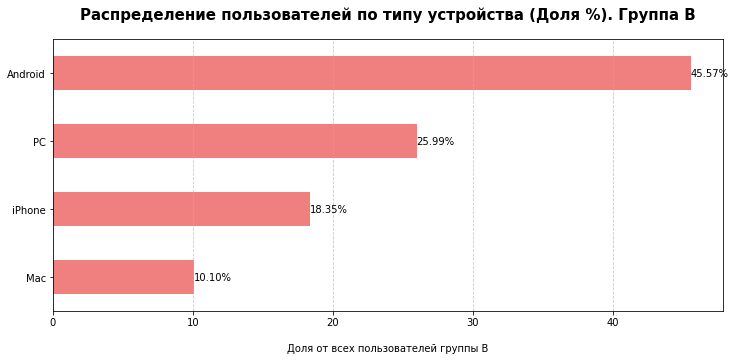

In [27]:
plt_a = plot_barh_with_shares(group_A_device, 'device','share %',  'Распределение пользователей по типу устройства (Доля %). Группа A', 'Доля от всех пользователей группы A', 'lightblue')
plt_b = plot_barh_with_shares(group_B_device, 'device','share %',  'Распределение пользователей по типу устройства (Доля %). Группа B', 'Доля от всех пользователей группы B', 'lightcoral')
plt_a.show()
plt_b.show()

**Вывод:**
* Распределение пользователей между устройствами по группам примерно одинаковое. Существенных различий не выявлено.


#### 3.4. Равномерность распределения пользователей по регионам
Убедимся, что пользователи равномерно распределены по регионам.

In [28]:
# Поделим датафрейм на две группы и проведем группировку по региону

group_A_region = group_A.groupby('region')['user_id'].nunique().reset_index().rename(columns={'user_id': 'users'})
group_B_region = group_B.groupby('region')['user_id'].nunique().reset_index().rename(columns={'user_id': 'users'})
group_A_region['share %'] = round(group_A_region['users']/group_A_region['users'].sum() *100,2)
group_B_region['share %'] = round(group_B_region['users']/group_B_region['users'].sum() *100,2)

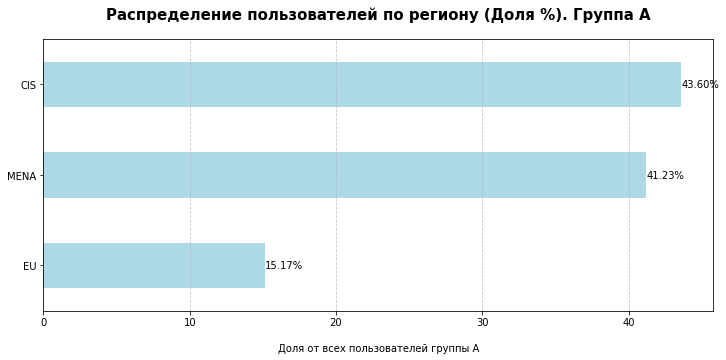

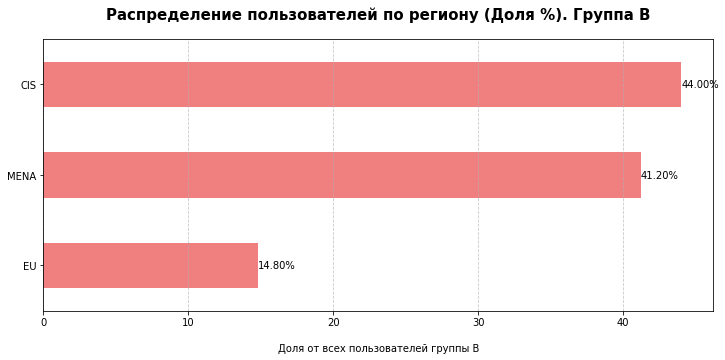

In [29]:
plt_a = plot_barh_with_shares(group_A_region, 'region','share %',  'Распределение пользователей по региону (Доля %). Группа A', 'Доля от всех пользователей группы A', 'lightblue')
plt_b = plot_barh_with_shares(group_B_region, 'region','share %',  'Распределение пользователей по региону (Доля %). Группа B', 'Доля от всех пользователей группы B', 'lightcoral')
plt_a.show()
plt_b.show()

**Вывод:**
* Распределение пользователей между регионами по группам примерно одинаковое. Существенных различий не выявлено.

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста за первый день можно сформировать следующие выводы:

- Различие между группами по кол-ву пользователей минимально и составляет менее 1%

- Выборки независимы и пересечение одного пользователя между двумя группами отсутствует

- Между тестовой и контрольной группой различия долей по регионам и типам устройств от всех пользователей группы минимальны

***A/B тестирование проходит корректно.***

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у нас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики
Проведем подготовку данных и создадим доп колонку успешных сессий

In [30]:
# загружаем DF и создаем доп столбец
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

sessions_test['good_session'] = 0
sessions_test.loc[sessions_test['page_counter'] >= 4, 'good_session'] = 1

sessions_test.sample(3)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
49534,6467B6108836570A,DCED620C32DB29C7,2025-10-15,2025-10-15 21:17:49,2025-10-15,1,1,2,CIS,PC,B,0
61685,500B80F1A3004388,4E44A0961A4F727A,2025-10-20,2025-10-20 15:24:04,2025-10-16,4,0,3,CIS,PC,A,0
76491,EFC9C5B4E4D50C69,FAA995D6980959AC,2025-10-15,2025-10-15 09:12:18,2025-10-15,1,0,4,MENA,PC,A,1


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и мы будем сравнивать две сопоставимые группы.

Выдвинем гипотезы для среднего сессий за день:
* H0 ​
 : μ 
A
​
 =μ 
B
​ - среднее значение сессий в день у двух групп не имеет статистических различий
* H1 : μ 
A
​
 !=μ 
B - среднее значение сессий в день у двух групп различаются


In [31]:
# Поделим датафрейм на две группы и проведем расчеты
group_A = sessions_test[sessions_test['test_group'] == 'A']
group_B = sessions_test[sessions_test['test_group'] == 'B']

group_A_sessions = group_A.groupby('session_date')['session_id'].count()
group_B_sessions = group_B.groupby('session_date')['session_id'].count()

In [32]:
# Сравним средние значения между группами
a_mean = group_A_sessions.mean().item()
b_mean = group_B_sessions.mean().item()
f"Среднее значение сессий в день для группы A {a_mean}, для группы B {b_mean}, различие {round(1-b_mean/a_mean,2) *100}%"

'Среднее значение сессий в день для группы A 2477.55, для группы B 2522.7, различие -2.0%'

In [33]:
# Проведем статистический тест

test_result = ttest_ind(
    group_A_sessions,
    group_B_sessions,
    alternative='two-sided'
) 

alpha = 0.05

if test_result.pvalue > alpha:
    display(f'pvalue={test_result.pvalue} > {alpha}')
    display('Не получилось отвергнуть нулевую гипотезу, статистически значимые различия по кол-ву сессий в день между группами не выявлены')
else:
    display(f'pvalue={test_result.pvalue} < {alpha}')
    display('Отвергаем нулевую гипотезу. Статистически значимые различия по кол-ву сессий в день между группами выявлены') 

'pvalue=0.938219304859116 > 0.05'

'Не получилось отвергнуть нулевую гипотезу, статистически значимые различия по кол-ву сессий в день между группами не выявлены'

**Вывод:**
* При первичном анализе двух групп A/B тестирования, статистически значимых различий по среднему кол-ву сессий в день не выявлено. P-value 0.94, означает что нельзя отвергнуть гипотезу о равенстве двух выборок.

#### 4.3. Сравнение доли успешных сессий

Переходим к анализу ключевой метрики — доли успешных сессий.

In [34]:
# Посчитаем общее кол-во групп
n_a = group_A.shape[0]
n_b = group_B.shape[0]

# Посчитаем кол-во успешных сессий
m_a = group_A['good_session'].sum()
m_b = group_B['good_session'].sum()

p_a = m_a/n_a
p_b = m_b/n_b

f"Доля успешных сессий в группе A {round(p_a,2)}, в группе B {round(p_b,2)}. Разница между группами B и A примерно {round((p_b - p_a)*100, 1)}%"

'Доля успешных сессий в группе A 0.31, в группе B 0.32. Разница между группами B и A примерно 1.1%'

**Вывод:**
* Доля успешных сессий в группе A - 31%, в группе B - 32%. Разница между успешными сессиями примерно 1.1%. Необходимо провести статест для понимания статистической значимости этой разницы.

#### 4.4. Насколько статистически значимо изменение ключевой метрики

Используя статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.


In [35]:
# Проводим Z-тест пропорций

# Проверим достаточное кол-во данных
if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    display('Предпосылка о достаточном количестве данных выполняется!')
else:
    display('Предпосылка о достаточном количестве данных НЕ выполняется!')
  

# Стат тест
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)


if p_value_ztest > alpha:
    display(f'pvalue={p_value_ztest} > {alpha}')
    display('Нулевая гипотеза находит подтверждение!')
else:
    display(f'pvalue={p_value_ztest} < {alpha}')
    display('Нулевая гипотеза не находит подтверждения!')


'Предпосылка о достаточном количестве данных выполняется!'

'pvalue=0.0001574739988036123 < 0.05'

'Нулевая гипотеза не находит подтверждения!'

**Вывод:**
* P-value составляет 0.0002, что ниже уровня значимости в 0.05. Нулевая гипотеза не находит подтверждения

#### 4.5. Вывод по результатам A/B-эксперимента

- Длительность эксперимента составила 20 дней. В эксперименте участвовало 15 163 уникальных пользователя для группы A и 15 416 уникальных пользователей для группы B. В эксперименте была 49 551 сессия для группы A и 50 454 сессии для группы B.

- Внедрение нового рекомендательного алгоритма повлияло на долю успешных сессий (сессий, где было просмотрено более 4-х страниц). Доля таких сессий для группы B, где применялся новый алгоритм, была на 1.1% больше, чем в группе A. Это в сочетании с результатом статистического теста показывает на статистически значимое различие между группами.

- P-value составляет 0.0002, что ниже уровня значимости в 0.05. Нулевая гипотеза о равенстве ключевого показателя не находит подтверждения.

- Можно внедрять данную рекомендательную систему для всех пользователей в приложении.